# Experiment 1

## Seam Carving

In [1]:
import matplotlib.pyplot as plt

from skimage import io, transform, util, data, draw
import numpy as np
from skimage import filters, color

from scipy import ndimage as ndi
from matplotlib import gridspec

In [2]:
def imread(filename):
    """For convenience since pixels are natively 8 bit ints"""
    return util.img_as_float(io.imread(filename))

def backward_energy(img, border=True):
    if border is True:
        eimage = filters.sobel(color.rgb2gray(img))
        eimage[0] += 100000
        eimage[-1] += 100000
        eimage[...,0] += 100000
        eimage[..., -1] += 100000
        return eimage
        
    return filters.sobel(color.rgb2gray(img))


def forward_energy(img):
    height = img.shape[0]
    width = img.shape[1]
    I = color.rgb2gray(img)
    
    energy = np.zeros((height, width))
    m = np.zeros((height, width))
    
    U = np.roll(I, 1, axis=0)
    L = np.roll(I, 1, axis=1)
    R = np.roll(I, -1, axis=1)
    
    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU
    
    for i in range(1, height):
        mU = m[i-1]
        mL = np.roll(mU, 1)
        mR = np.roll(mU, -1)
        
        mULR = np.array([mU, mL, mR])
        cULR = np.array([cU[i], cL[i], cR[i]])
        mULR += cULR

        argmins = np.argmin(mULR, axis=0)
        m[i] = np.choose(argmins, mULR)
        energy[i] = np.choose(argmins, cULR)
        
    return energy

In [3]:
def getMaps(image, eimage):
    """
    Calculate the cumulative minimum energy M
    
    :param image: image to find the seam
    :param f: energy map function
    """
    rows, columns, _ = image.shape
    energy_map = eimage

    current_map = energy_map.copy()
    goback = np.zeros_like(current_map, dtype = np.int)

    for i in range(1, rows):
        for j in range(0, columns):
            if j == 0:
                min_index = np.argmin(current_map[i - 1, j : j + 2])
                goback[i, j] = min_index + j
                min_energy = current_map[i - 1, min_index + j]

            else:
                min_index = np.argmin(current_map[i - 1, j - 1 : j + 2])
                goback[i, j] = min_index + j -1
                min_energy = current_map[i - 1, min_index + j - 1]

            current_map[i, j] += min_energy

    return current_map, goback

def find_optimal_seam(img, mask, mapping_function, f):
    """
    Find the optimal seam of image

    :param img: original size of image
    :param mask: masked_img
    :param f: energy map function
    """
    n, m, _ = img.shape
    m1 = sum(mask[0])
    
    new_img = img[mask].reshape((n, m1, 3))
    mapping_function = mapping_function[mask].reshape((n, m1, 2))
    
    eimage = f(new_img)
    cMap, goback = getMaps(new_img, eimage) 
    cMap, goback = getMaps(new_img, eimage)
    
    j = np.argmin(cMap[-1])
    
    for i in reversed(range(n)):
        mask[tuple(mapping_function[i, j])] = False
        j = goback[i, j]

    return mask

def seam_carving(img, f, r, directional):
    """
    Retargeting the image from n x m to (n-r x m) or (n x m-r)

    :param img: image to do the retargeting
    :param f: energy map function
    :param r: r
    :param directional: 0 for vertical 1 for horizontal
    """
    if directional == 1:
        img = np.rot90(img, 1, (0,1))
        n, m, _ = img.shape
    else:
        n, m, _ = img.shape
        
    mapping_function = np.array([[[i, j] for j in range(m)] for i in range(n)], dtype=np.int)
    mask = np.ones((n, m), dtype=np.bool)
    
    for i in range(r):
        mask = find_optimal_seam(img, mask, mapping_function, f) 
        
    res_img = img.copy()
    res_img = res_img[mask].reshape((n, m - r, 3))

    mask = np.logical_not(mask)
    seam_img = img.copy()
    
    seam_img[..., 0][mask] = 1.
    seam_img[..., 1][mask] = 0.
    seam_img[..., 2][mask] = 0.
    
    if directional == 1:
        seam_img = np.rot90(seam_img, 3, (0,1))
        res_img = np.rot90(res_img, 3, (0,1))
    return seam_img, res_img

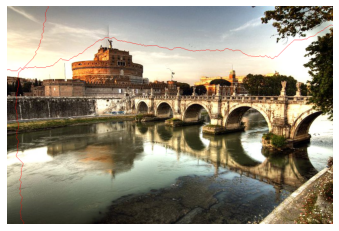

In [5]:
setangle = imread("images/SetAngle.jpg")
seam_img, carved_img = seam_carving(setangle, forward_energy, 1, 0)
seam_img, carved_img = seam_carving(seam_img, forward_energy, 1, 1)
plt.axis('off')
plt.imshow(seam_img)

## Comparison between backward and forward energy

In [4]:
def compare_energy(img, n, filename):
    """
    A helper function to compare backward and forward energy.
    
    :param img: image to carve
    :param int n: number of seams to carve
    """
    w = img.shape[1]
    gs = gridspec.GridSpec(3, 3,
                       width_ratios=[w, w, w-n],
                       height_ratios=[1, 1, 1],
                       )
    plt.figure(figsize=(14, 14))
    
    plt.subplot(gs[0])
    plt.axis('off')
    plt.imshow(img)
    plt.title('Original Image',y=-0.2)
    
    plt.subplot(gs[3])
    plt.axis('off')
    plt.imshow(backward_energy(img, False))
    plt.title('Backward Energy',y=-0.2)

    plt.subplot(gs[4])
    seam_img, carved_img = seam_carving(img, backward_energy, n, 0)
    plt.axis('off')
    plt.imshow(seam_img)
    plt.title('Backward Seams',y=-0.2)
    
    plt.subplot(gs[5])
    plt.axis('off')
    plt.imshow(carved_img)
    plt.title('Backward Carving',y=-0.2)
    
    plt.subplot(gs[6])
    plt.axis('off')
    plt.imshow(forward_energy(img))
    plt.title('Forward Energy',y=-0.2)
    
    plt.subplot(gs[7])
    seam_img, carved_img = seam_carving(img, forward_energy, n, 0)
    plt.axis('off')
    plt.imshow(seam_img)
    plt.title('Forward Seams',y=-0.2)
    
    plt.subplot(gs[8])
    plt.axis('off')
    plt.imshow(carved_img)
    plt.title('Forward Carving',y=-0.2)
    #plt.savefig(f"results/{filename}_1.png", bbox_inches='tight')
    plt.tight_layout()
    plt.show()

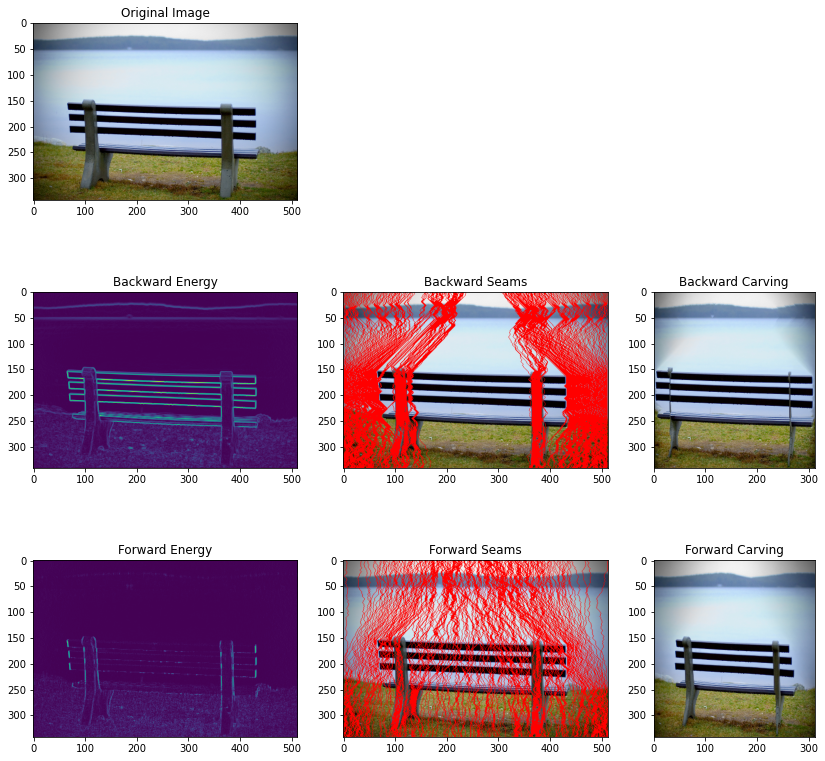

In [61]:
bench = imread('images/bench3.png')
compare_energy(bench, 200, "bench200")

## Image Retargeting

In [5]:
def find_optimal_seam(img, eimage, directional):
    """
    Find the optimal seam of image

    :param img: original size of image
    :param mask: masked_img
    :param f: energy map function
    :param directional: 0 for vertical 1 for horizontal
    
    return 
    """
    if directional == 1:
        img = np.rot90(img, 1, (0, 1))
        eimage = np.rot90(eimage, 1, (0, 1))
    
    n, m, _ = img.shape
    cMap, goback = getMaps(img, eimage)
    j = np.argmin(cMap[-1])
    
    mask = np.ones((n,m), dtype=np.bool)
    for i in reversed(range(n)):
        mask[i, j] = False
        j = goback[i, j]
    
    mask = np.stack([mask] * 3, axis = 2)
    img = img[mask].reshape((n, m - 1, 3))
    
    if directional == 1:
        img = np.rot90(img, 3, (0,1))
    return np.min(cMap[-1]), img


def img_retargeting(img, f, r, c):
    """
    Retargeting the image from n x m to n-r x m-c

    :param img: image to do the retargeting
    :param f: energy map function
    :param r: r
    :param c: c
    """
    n, m, _ = img.shape

    T = np.zeros((c + 1), dtype=np.float)
    T_img = [img.copy()]

    # T[0,0] = 0
    # T[0, j] = T[0, j-1] + E(s_c(0,j-1))
    for j in range(1, c + 1):
        min_energy, new_img = find_optimal_seam(T_img[j - 1], f(T_img[j - 1]), 0)
        T[j] = T[j - 1] + min_energy
        T_img.append(new_img)
        #print_seam_img(new_mask, img)

    for i in range(1, r + 1):
        min_energy, new_img = find_optimal_seam(T_img[0], f(T_img[0]), 1)
        T[0] = T[0] + min_energy
        T_img[0] = new_img
        #print_seam_img(new_mask, img)

        for j in range(1, c + 1):
            v_min_energy, v_new_img = find_optimal_seam(T_img[j - 1], f(T_img[j - 1]), 0)
            h_min_energy, h_new_img = find_optimal_seam(T_img[j], f(T_img[j]), 1)
            #print_seam_img(v_new_mask, img)
            #print_seam_img(h_new_mask, img)
            if (T[j - 1] + v_min_energy) < (T[j] + h_min_energy):
                T[j] = T[j - 1] + v_min_energy
                T_img[j] = v_new_img
            else:
                T[j] = T[j] + h_min_energy
                T_img[j] = h_new_img
    
    return T_img[c]

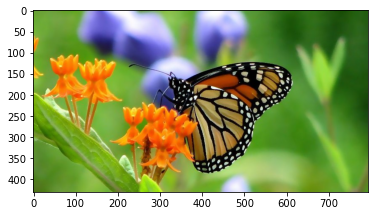

In [16]:
butterfly = imread("images/butterfly.jpg")
plt.imshow(butterfly)

Wall time: 5h 48min 2s
(430, 794, 3) (380, 594, 3)


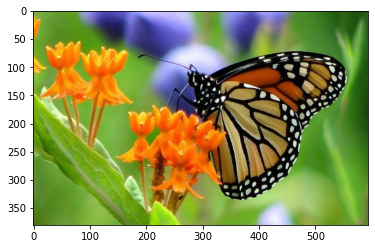

In [17]:
%time img1 = img_retargeting(butterfly, forward_energy, 50,200)
print(butterfly.shape, img1.shape)
plt.imshow(img1)

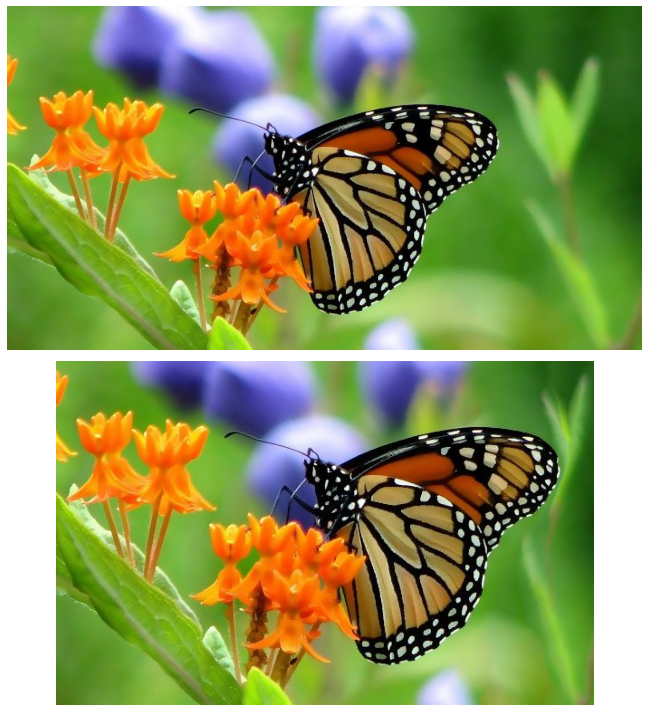

In [29]:
w = butterfly.shape[1]
n = 200
gs = gridspec.GridSpec(2,1)
                   #width_ratios=[w, w-n],
                   #height_ratios=[1],
                   #)

plt.figure(figsize=(10,10))
plt.subplot(gs[0])
plt.axis('off')
plt.imshow(butterfly)
#plt.title('Original Image')

plt.subplot(gs[1])
plt.axis('off')
plt.imshow(butterfly_seam)
#plt.title('Resized Image')

plt.tight_layout()
plt.savefig(f"results/resized.png", bbox_inches='tight')
plt.show()

## Object Removal

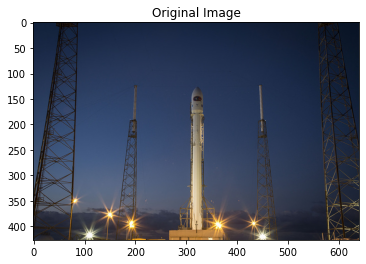

In [38]:
rocket = data.rocket()
rocket = util.img_as_float(rocket)
eimg = filters.sobel(color.rgb2gray(rocket))

plt.title('Original Image')
plt.imshow(rocket)

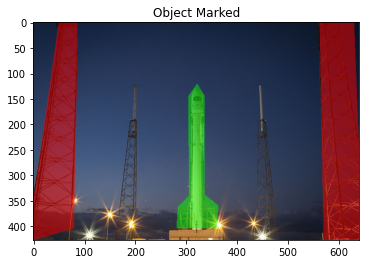

In [39]:
masked_img = rocket.copy()
hl_reserved_color = np.array([0, 1, 0])
hl_removed_color = np.array([1, 0, 0])

poly = [(404, 281), (404, 360), (359, 364), (338, 337), (145, 337), (120, 322),
        (145, 304), (340, 306), (362, 284)]
poly_1 = [(427, 0), (350,0), (0, 50), (0, 88), (404, 80)]
poly_2 = [(427,570), (0, 562), (0, 630), (250, 640), (427, 640)]
pr = np.array([p[0] for p in poly])
pc = np.array([p[1] for p in poly])
pr_1 = np.array([p[0] for p in poly_1])
pc_1 = np.array([p[1] for p in poly_1])
pr_2 = np.array([p[0] for p in poly_2])
pc_2 = np.array([p[1] for p in poly_2])

rr, cc = draw.polygon(pr, pc)
rr_1, cc_1 = draw.polygon(pr_1, pc_1)
rr_2, cc_2 = draw.polygon(pr_2, pc_2)

masked_img[rr, cc, :] = masked_img[rr, cc, :]*0.5 + hl_reserved_color*.5
masked_img[rr_1, cc_1, :] = masked_img[rr_1, cc_1, :]*0.5 + hl_removed_color *.5
masked_img[rr_2, cc_2, :] = masked_img[rr_2, cc_2, :]*0.5 + hl_removed_color *.5
plt.figure()
plt.title('Object Marked')

plt.imshow(masked_img)

C:\Users\ouyhlan\.conda\envs\myenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


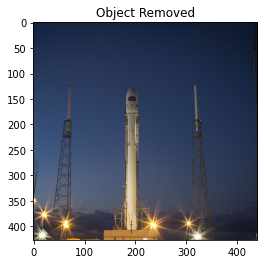

In [40]:
eimage = backward_energy(rocket)
eimage[rr, cc] += 10000
eimage[rr_1, cc_1] -= 10000
eimage[rr_2, cc_2] -= 1000

plt.figure()
plt.title('Object Removed')
out = transform.seam_carve(img, eimage, 'vertical', 200)
resized = transform.resize(img, out.shape, mode='reflect')
plt.imshow(out)
plt.show()

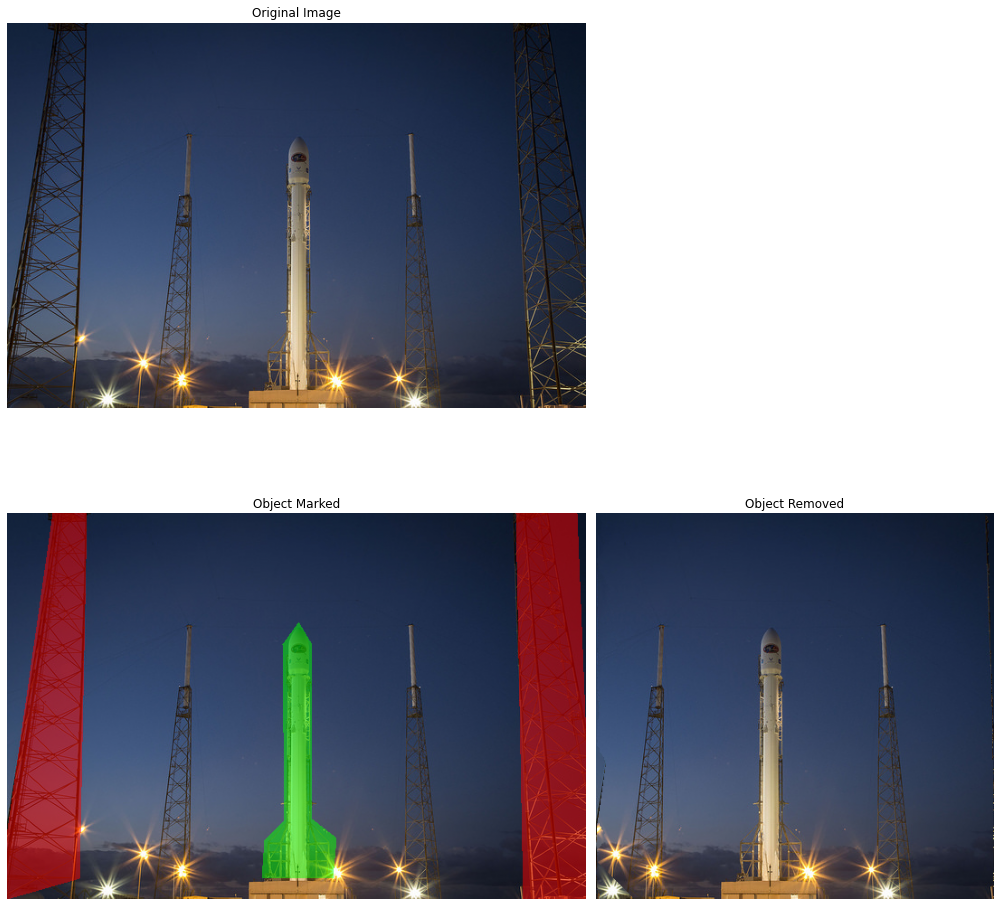

In [41]:
w = rocket.shape[1]
n = 200
gs = gridspec.GridSpec(2,2,
                   width_ratios=[w, w-n],
                   height_ratios=[1, 1],
                   )

plt.figure(figsize=(14,14))
plt.subplot(gs[0])
plt.axis('off')
plt.imshow(rocket)
plt.title('Original Image')

plt.subplot(gs[2])
plt.axis('off')
plt.imshow(masked_img)
plt.title('Object Marked')

plt.subplot(gs[3])
plt.axis('off')
plt.imshow(out)
plt.title('Object Removed')

plt.tight_layout()
plt.savefig(f"results/removal.png", bbox_inches='tight')
plt.show()

## Image Enlarging

In [49]:
def add_k_seam(img, eimage, k, directional):
    """
    Add one seam to the image 

    :param img: original size of image
    :param eimage: energy map of image
    :param k: the number of seam to add
    :param directional: 0 for vertical 1 for horizontal
    
    return the desired image 
    """
    if directional == 1:
        img = np.rot90(img, 1, (0,1))
        eimage = np.rot90(eimage, 1, (0, 1))
    
    n, m, _ = img.shape
    cMap, goback = getMaps(img, eimage)
    j_arr = np.sort(np.argsort(cMap[-1])[-k:])
    
    output_img = np.zeros((n, m + k, 3))
    
    for i in reversed(range(n)):
        pre_new_j = 0
        pre_old_j = 0
        for pre_num, j in enumerate(j_arr):
            cur_new_j = pre_num + j
            for channel in range(3):
                if j == 0:
                    p = np.average(img[i, j: j + 2, channel])
                else:
                    p = np.average(img[i, j - 1: j + 2, channel])
                
                output_img[i, pre_new_j : cur_new_j + 1, channel] = img[i, pre_old_j : j + 1, channel]
                output_img[i, cur_new_j + 1, channel] = p
            pre_old_j = j + 1
            pre_new_j = cur_new_j + 2
            j_arr[pre_num] = goback[i, j]
        output_img[i, pre_new_j:] = img[i, pre_old_j:]
        j_arr = np.sort(j_arr)
    
    if directional == 1:
        output_img = np.rot90(output_img, 3, (0,1))
    return output_img

def img_enlarging(img, f, r, directional, alpha=1):
    """
    Enlarging the image from (n x m) to (n + r x m) or (n x m + r)

    :param img: image to do the retargeting
    :param f: energy map function
    :param k: k
    :param directional: 0 for vertical 1 for horizontal
    """

    if directional == 1:
        k = img.shape[0] * alpha
    else:
        k = img.shape[1] * alpha

    res_img = img
    while r > 0:
        k = np.max([np.min([int(k), r]),1])
        res_img = add_k_seam(res_img, f(res_img), k, directional)
        r -= k
        k *= alpha
    return res_img

Wall time: 662 ms
(738, 486, 3) (186, 374, 3)


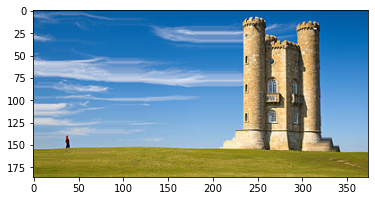

In [54]:
castle = imread("images/castle.png")
%time img1 = img_enlarging(castle, forward_energy, 100, 0)
print(fuji.shape, img1.shape)
plt.imshow(img1)

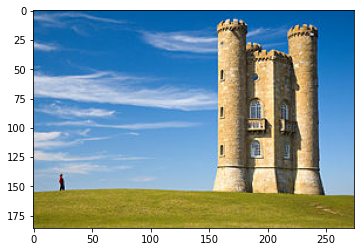

In [40]:
plt.imshow(castle)

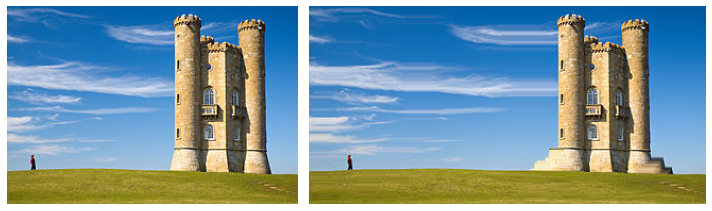

In [57]:
w = castle.shape[1]
n = 100
gs = gridspec.GridSpec(1, 2,
                   width_ratios=[w, w+n],
                   height_ratios=[1],
                   )

plt.figure(figsize=(10,10))
plt.subplot(gs[0])
plt.axis('off')
plt.imshow(castle)
#plt.title('Original Image')

plt.subplot(gs[1])
plt.axis('off')
plt.imshow(img1)
#plt.title('Resized Image')

plt.tight_layout()
plt.savefig(f"results/enlarge.png", bbox_inches='tight')
plt.show()